# <center>Quantum Optics Internship 2024, ML4Q</center>
## <center> Laser Gyroscope </center>
### <center> **Author**: Sahil Ugale </center>
#### <center>  Matriculation Number - 7406884 </center>

In [47]:
import numpy as np
import scipy.io
import pandas as pd
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from uncertainties import unumpy as unp
from uncertainties import ufloat
from scipy.stats import linregress
from scipy.constants import c, pi
import allantools
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("darkgrid")

# Compact rcParams configuration
plt.rcParams.update({
    'figure.figsize': (15, 7),
    'axes.labelsize': 18,
    'axes.titlesize': 20,
    'xtick.labelsize': 16,   
    'ytick.labelsize': 16,   
    'legend.fontsize': 18,
    'axes.titleweight': 'bold',
    'figure.dpi': 200,
    'font.family': 'Serif'
})

---
## (Task A): Operation of the gyroscope
---

### Record the cavity resonances and lock the first arm to the cavity

In [48]:
# Fast signal - C1 in V
# Slow signal - C2 in V

# Load data
data = pd.read_csv("PDH/G1_2_01.csv")
time = data["in s"]
fast_signal = data["C1 in V"]
slow_signal = data["C2 in V"]
abs_fast_signal = np.abs(fast_signal - np.mean(fast_signal))

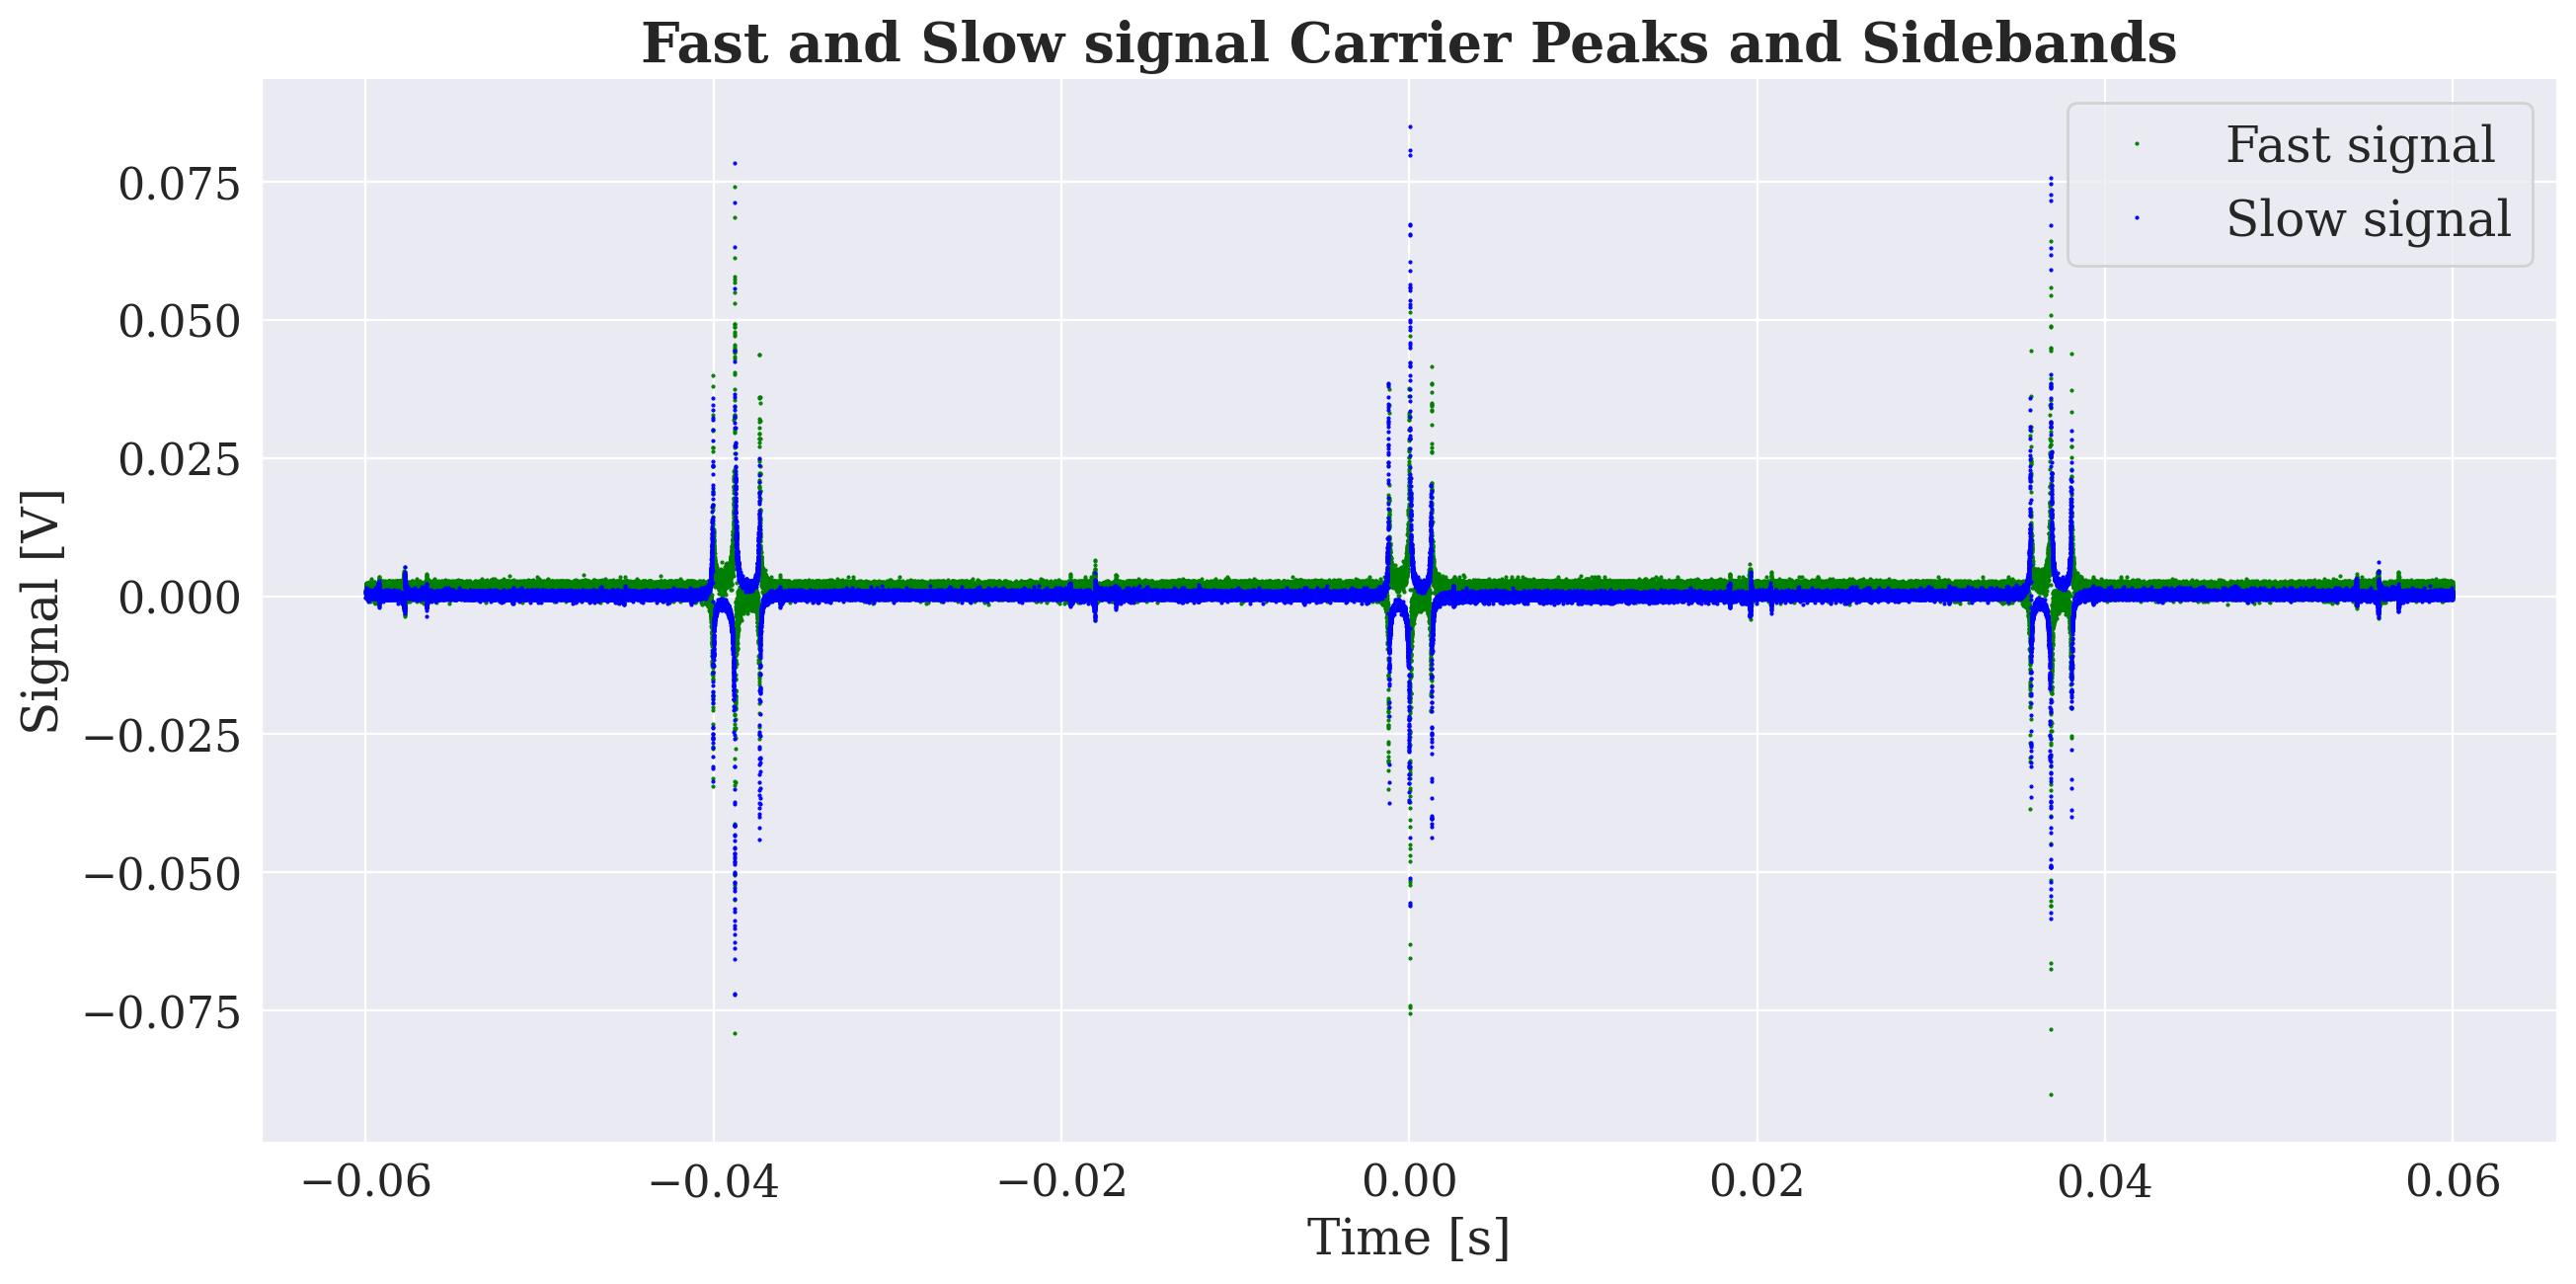

In [49]:
plt.plot(time, fast_signal, 'go', ms=0.5, label="Fast signal")
plt.plot(time, slow_signal, 'bo', ms=0.5, label="Slow signal")
plt.xlabel("Time [s]")
plt.ylabel("Signal [V]")
plt.title("Fast and Slow signal Carrier Peaks and Sidebands")
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [15]:
peaks, prop = find_peaks(abs_fast_signal, height=0.02, distance=1000)
time_peaks = time[peaks].array
signal_peaks = abs_fast_signal[peaks].array

In [16]:
def _1Lorentzian(x, amp, cen, wid, H):
    return H + (amp * wid ** 2 / ((x - cen) ** 2 + wid ** 2))

def _9Lorentzian(x, amp1, cen1, wid1, H1, amp2, cen2, wid2, H2, amp3, cen3, wid3, H3,
                    amp4, cen4, wid4, H4, amp5, cen5, wid5, H5, amp6, cen6, wid6, H6,
                    amp7, cen7, wid7, H7, amp8, cen8, wid8, H8, amp9, cen9, wid9, H9):
    return (H1 + (amp1 * wid1 ** 2 / ((x - cen1) ** 2 + wid1 ** 2)) +
            H2 + (amp2 * wid2 ** 2 / ((x - cen2) ** 2 + wid2 ** 2)) +
            H3 + (amp3 * wid3 ** 2 / ((x - cen3) ** 2 + wid3 ** 2)) +
            H4 + (amp4 * wid4 ** 2 / ((x - cen4) ** 2 + wid4 ** 2)) +
            H5 + (amp5 * wid5 ** 2 / ((x - cen5) ** 2 + wid5 ** 2)) +
            H6 + (amp6 * wid6 ** 2 / ((x - cen6) ** 2 + wid6 ** 2)) +
            H7 + (amp7 * wid7 ** 2 / ((x - cen7) ** 2 + wid7 ** 2)) +
            H8 + (amp8 * wid8 ** 2 / ((x - cen8) ** 2 + wid8 ** 2)) +
            H9 + (amp9 * wid9 ** 2 / ((x - cen9) ** 2 + wid9 ** 2)))

# time, abs_fast_signal, signal_peaks, and time_peaks
popt_9lor, pcov_9lor = curve_fit(_9Lorentzian, time, abs_fast_signal, 
                                 p0=[signal_peaks[0], time_peaks[0], 5.00e-05, 0,  
                                     signal_peaks[1], time_peaks[1], 5.00e-05, 0,  
                                     signal_peaks[2], time_peaks[2], 5.00e-05, 0,  
                                     signal_peaks[3], time_peaks[3], 5.00e-05, 0,  
                                     signal_peaks[4], time_peaks[4], 5.00e-05, 0,  
                                     signal_peaks[5], time_peaks[5], 5.00e-05, 0,  
                                     signal_peaks[6], time_peaks[6], 5.00e-05, 0,  
                                     signal_peaks[7], time_peaks[7], 5.00e-05, 0,  
                                     signal_peaks[8], time_peaks[8], 5.00e-05, 0]) 

# Extract standard deviations
perr_9lor = np.sqrt(np.diag(pcov_9lor))

# Extracting parameters for individual Lorentzians
pars_1 = popt_9lor[0:4] # sideband 1
pars_2 = popt_9lor[4:8] # carrier 1
pars_3 = popt_9lor[8:12] # sideband 2
pars_4 = popt_9lor[12:16] # sideband 1
pars_5 = popt_9lor[16:20] # carrier 2
pars_6 = popt_9lor[20:24] # sideband 2
pars_7 = popt_9lor[24:28] # sideband 1
pars_8 = popt_9lor[28:32] # carrier 3
pars_9 = popt_9lor[32:36] # sideband 2

# Calculating individual Lorentzian peaks
lor_peak_1 = _1Lorentzian(time, *pars_1)
lor_peak_2 = _1Lorentzian(time, *pars_2)
lor_peak_3 = _1Lorentzian(time, *pars_3)
lor_peak_4 = _1Lorentzian(time, *pars_4)
lor_peak_5 = _1Lorentzian(time, *pars_5)
lor_peak_6 = _1Lorentzian(time, *pars_6)
lor_peak_7 = _1Lorentzian(time, *pars_7)
lor_peak_8 = _1Lorentzian(time, *pars_8)
lor_peak_9 = _1Lorentzian(time, *pars_9)

# Calculating the combined Lorentzian fit
lor_fit = _9Lorentzian(time, *popt_9lor)

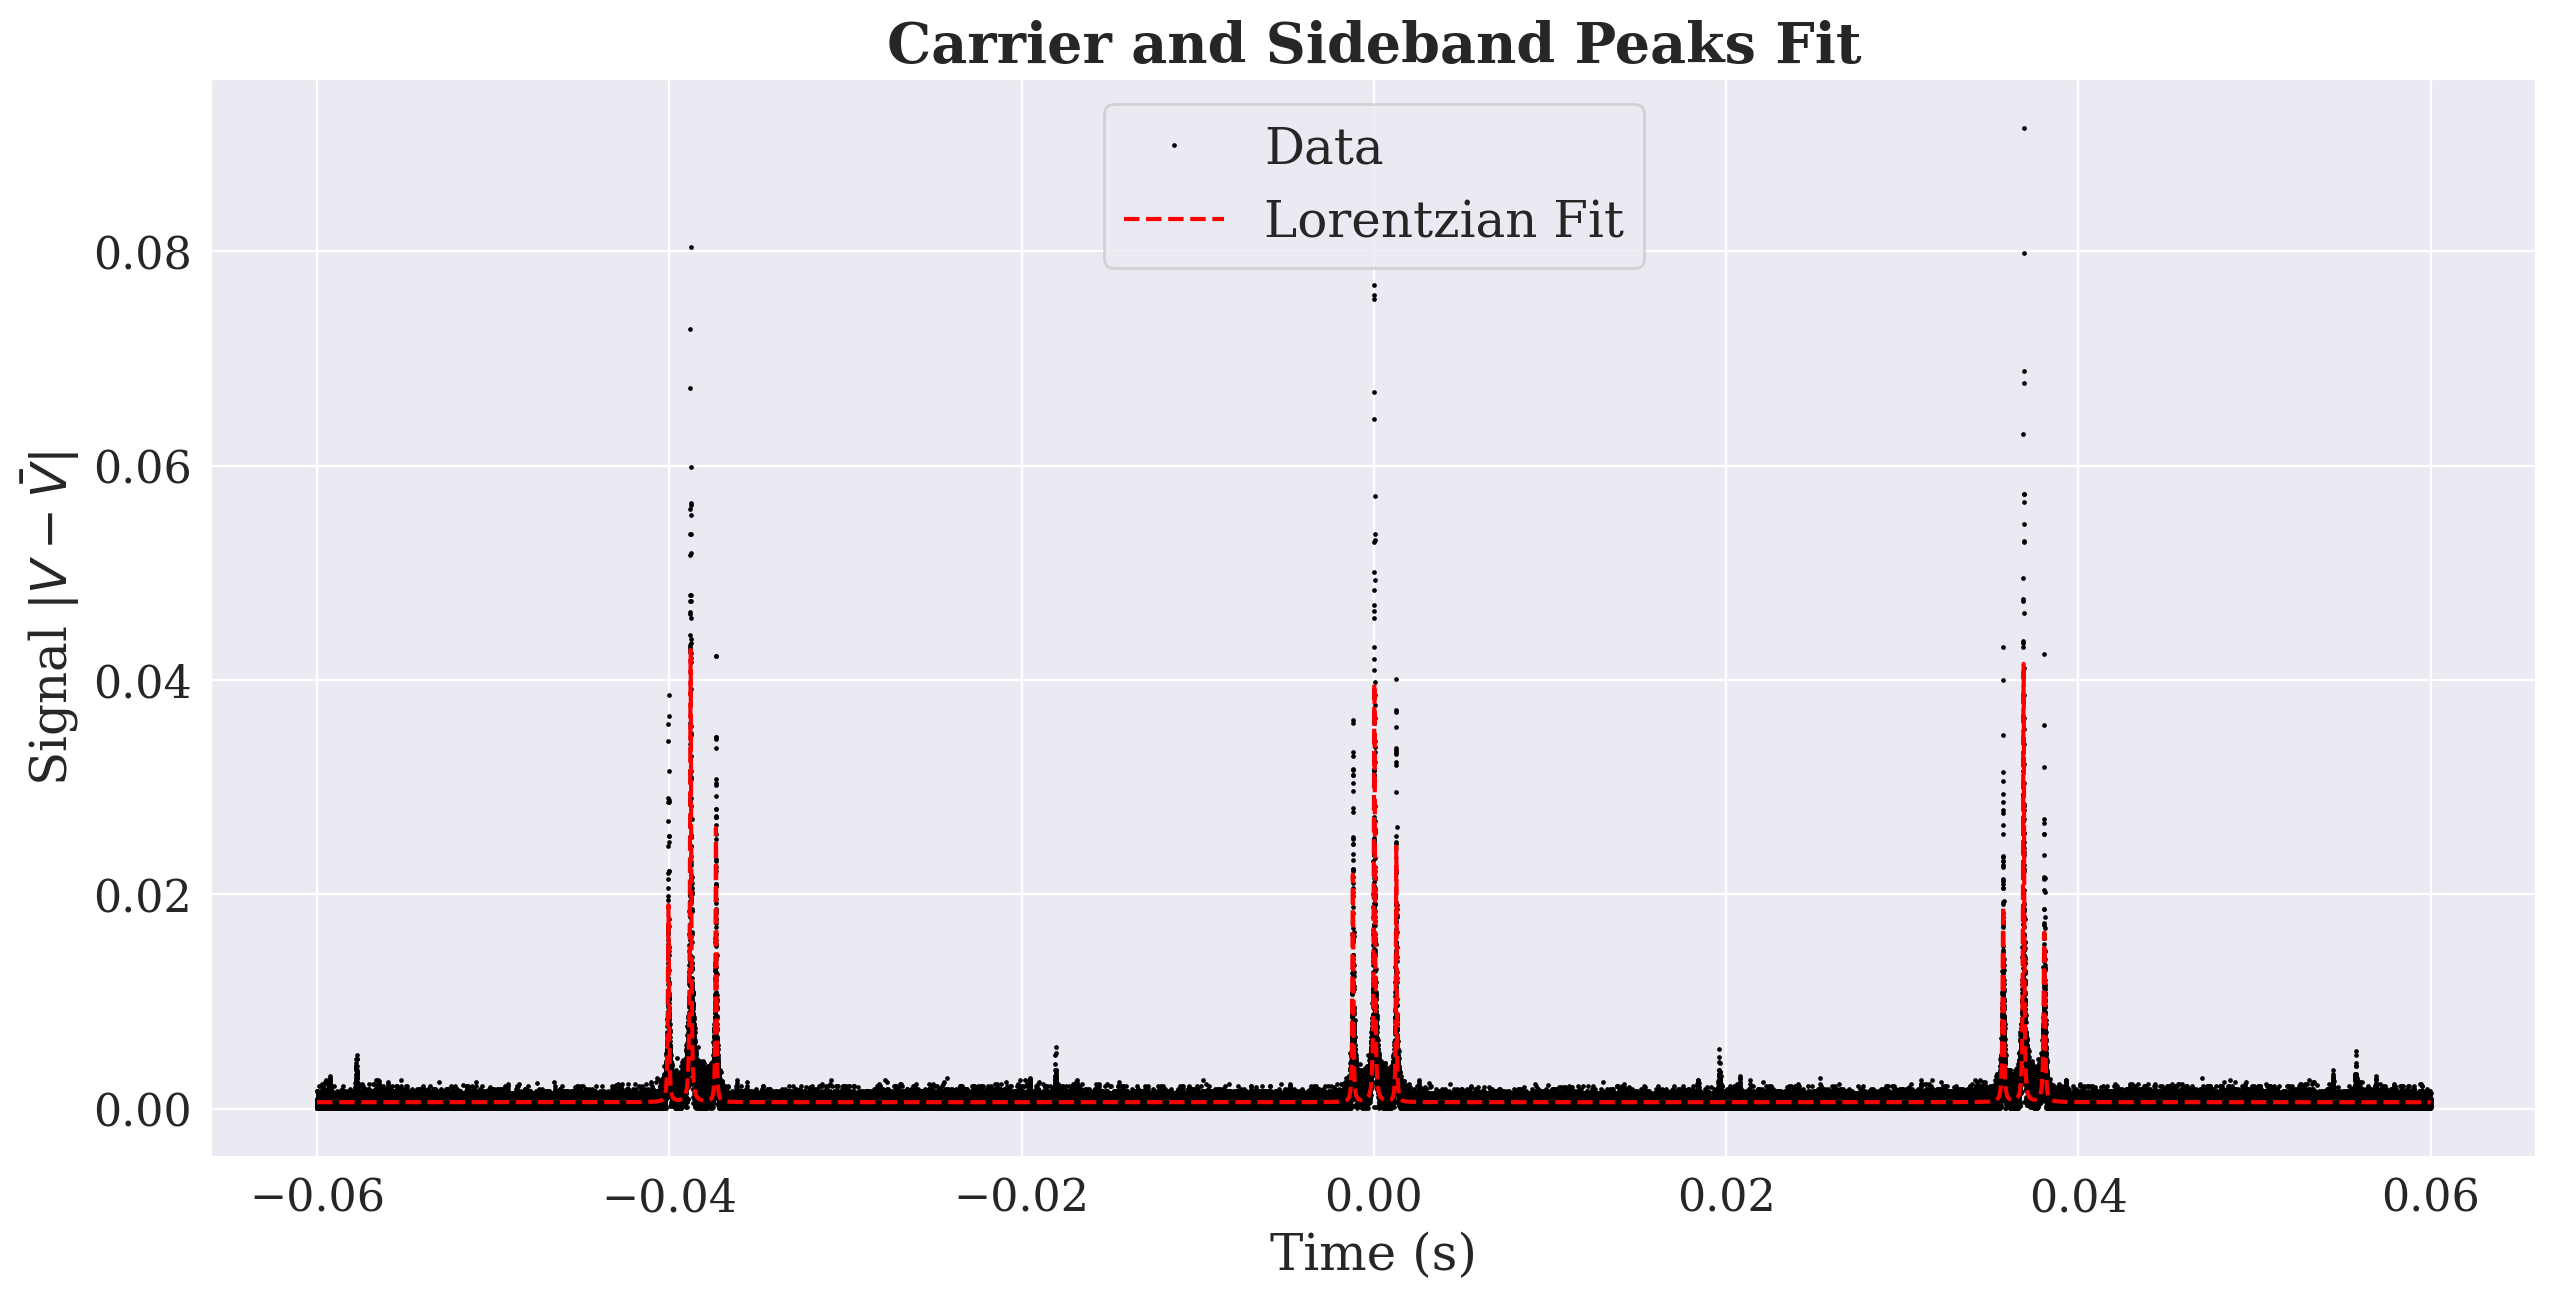

In [50]:
plt.plot(time, abs_fast_signal, "ko", ms=0.7, label="Data" )
plt.plot(time, lor_fit, "r--", label="Lorentzian Fit")
plt.xlabel("Time (s)")
plt.ylabel(r"Signal $| V - \bar{V} |$")
plt.title("Carrier and Sideband Peaks Fit")
plt.legend(loc='best')
plt.grid(True)
plt.show()

---
- Carrier 1 range = 21000:25000
- Carrier 2 range = 63000:66500
- Carrier 3 range = 102500:106000
---

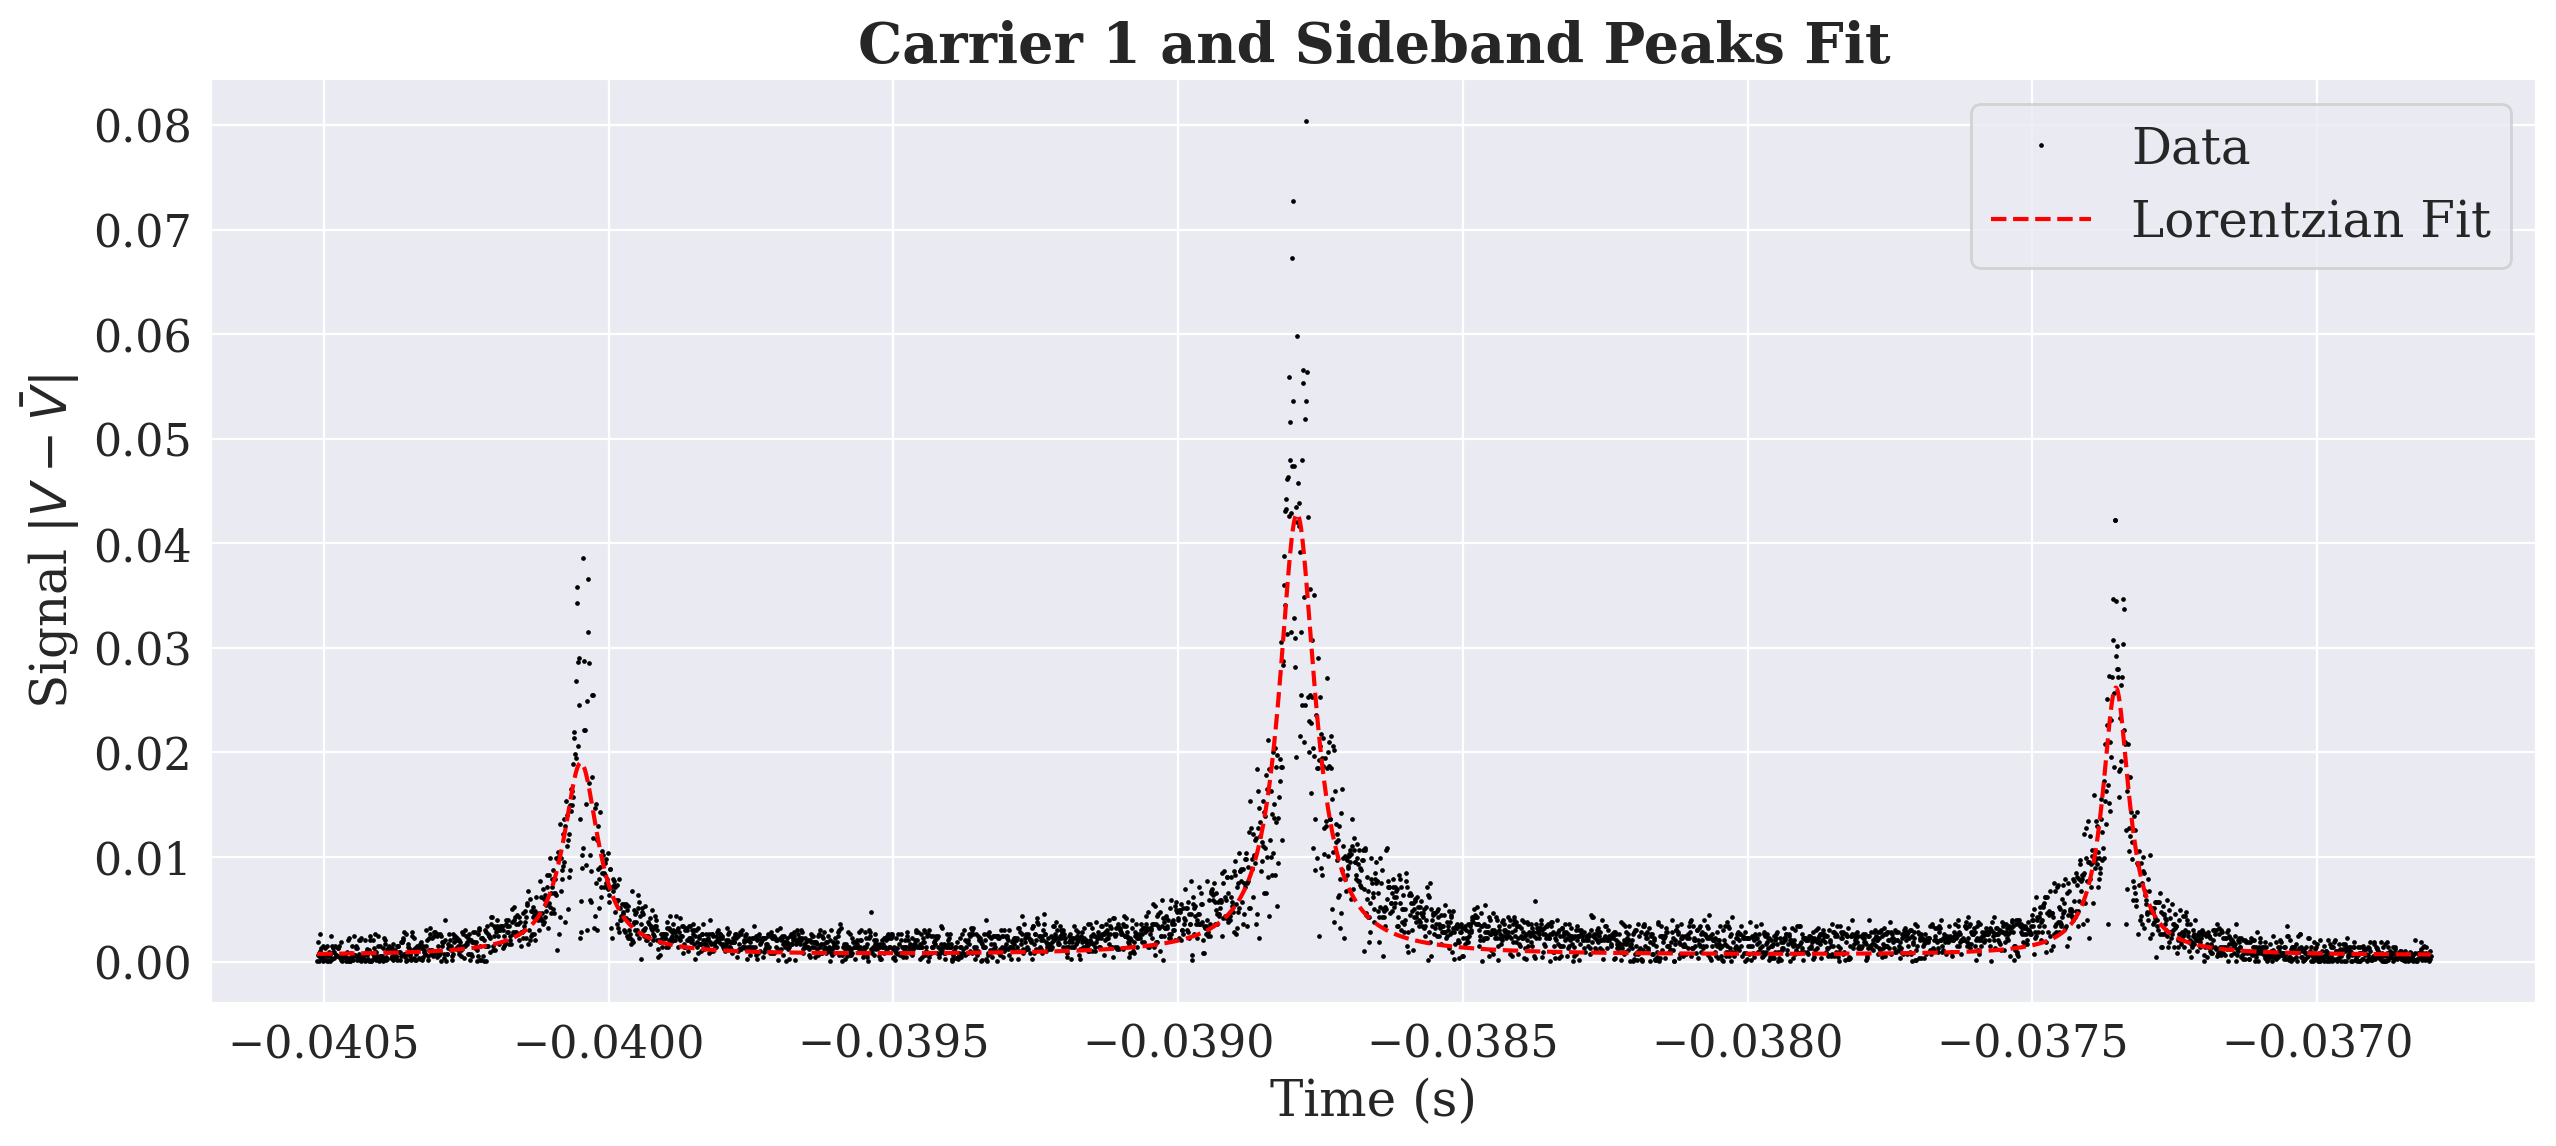

In [51]:
plt.figure(figsize=(15, 6))
plt.plot(time[21000:25000], abs_fast_signal[21000:25000], "ko", ms=0.7, label="Data" )
plt.plot(time[21000:25000], lor_fit[21000:25000], "r--", label="Lorentzian Fit")
plt.xlabel("Time (s)")
plt.ylabel(r"Signal $| V - \bar{V} |$")
plt.title("Carrier 1 and Sideband Peaks Fit")
plt.legend(loc='best')
plt.grid(True)
plt.show()

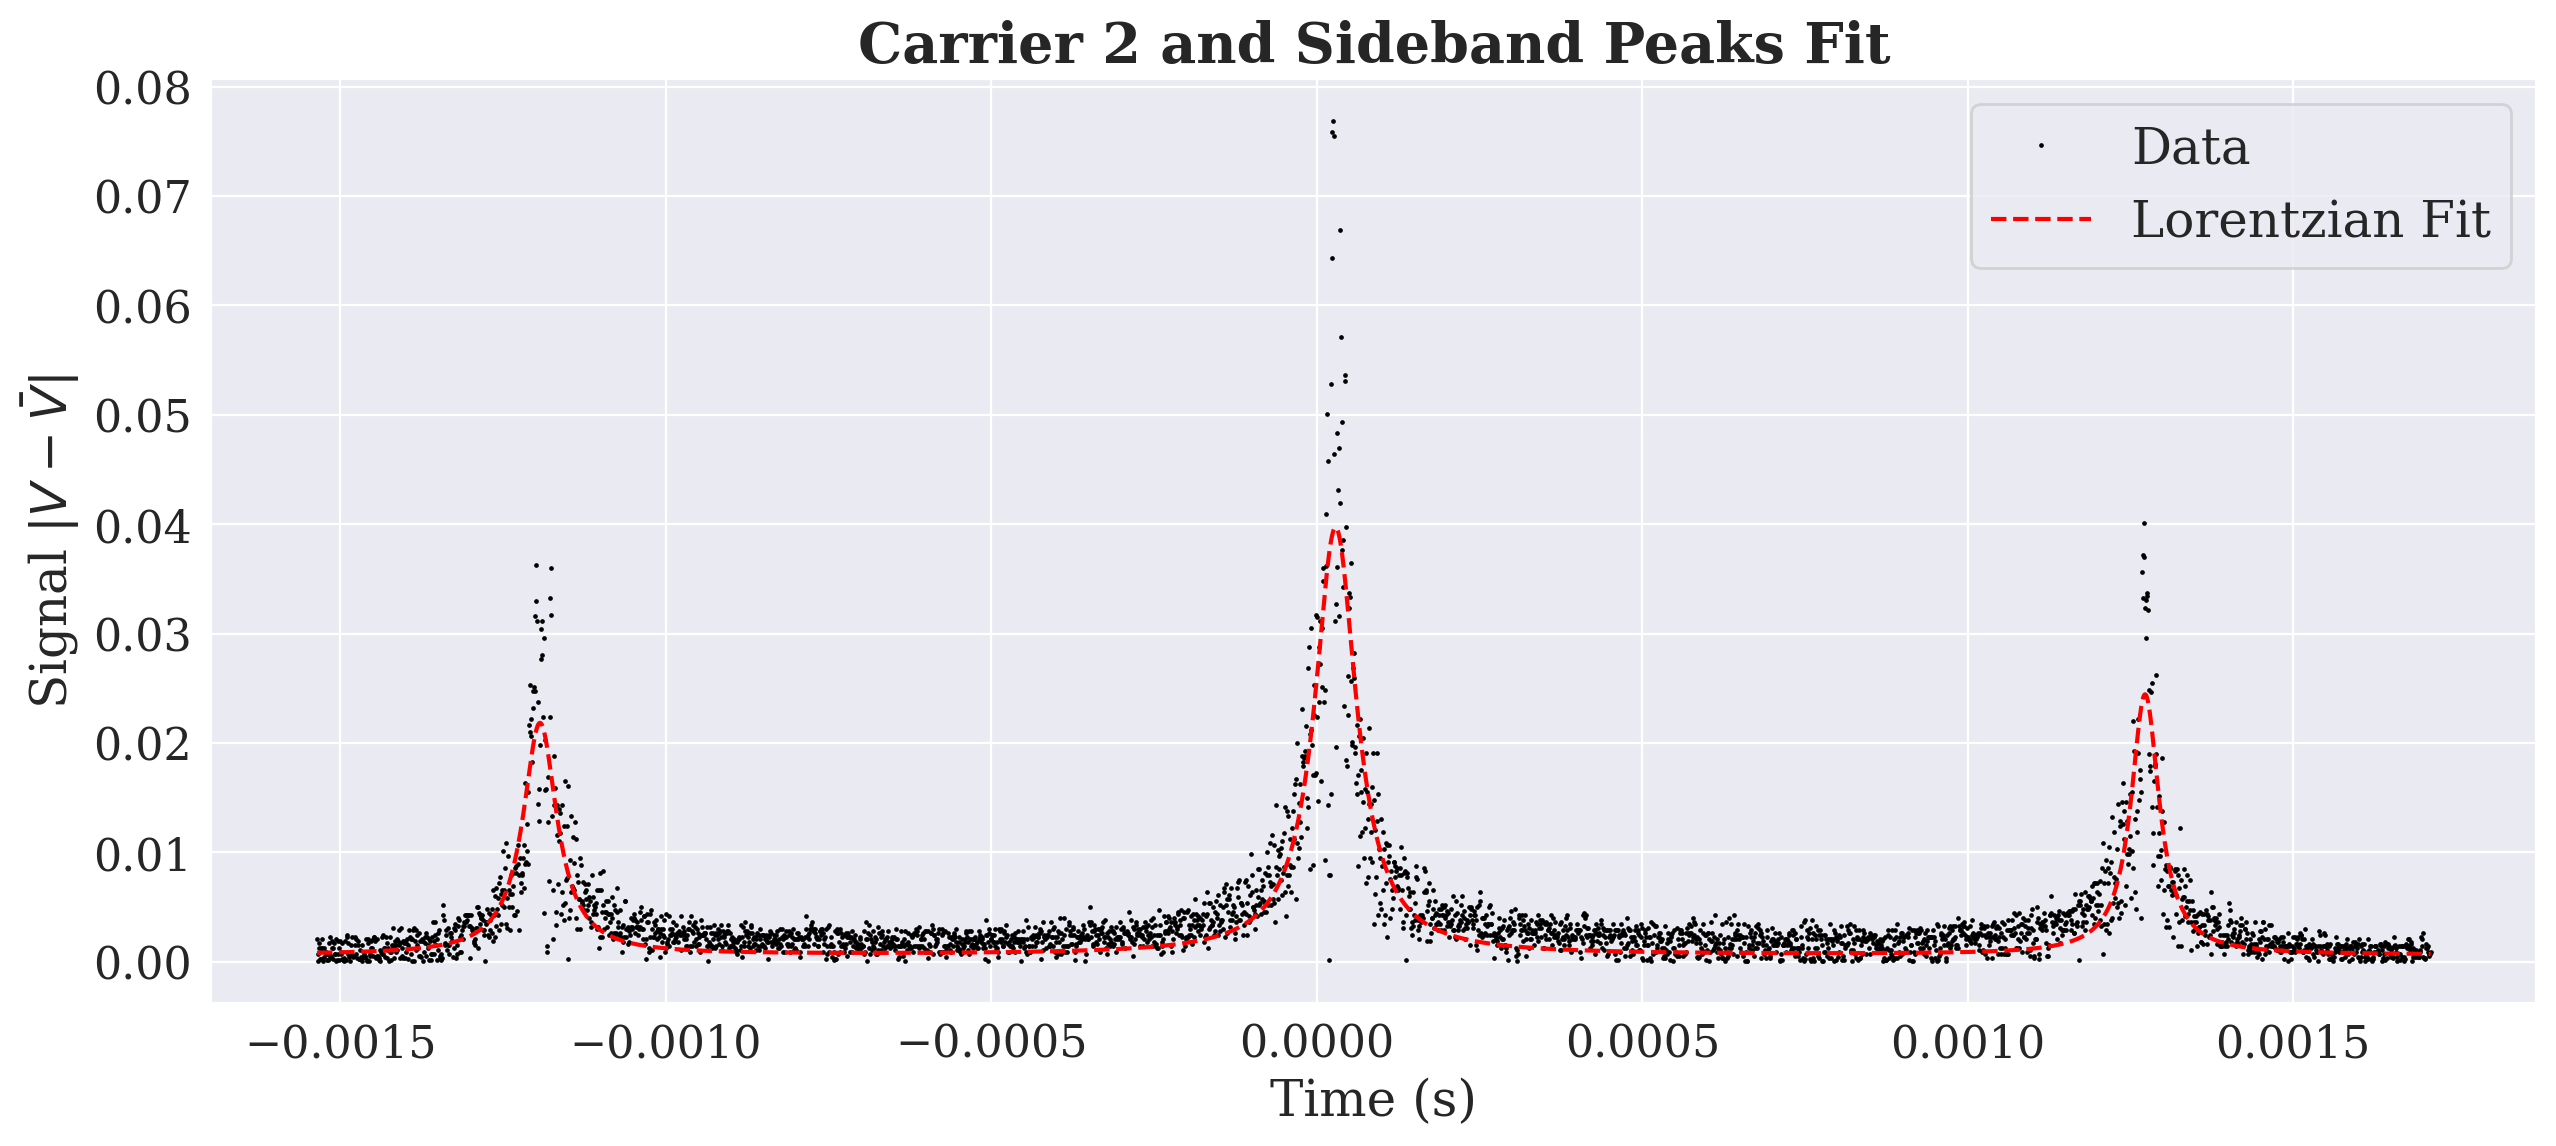

In [52]:
plt.figure(figsize=(15, 6), dpi=200)
plt.plot(time[63000:66500], abs_fast_signal[63000:66500], "ko", ms=0.7, label="Data" )
plt.plot(time[63000:66500], lor_fit[63000:66500], "r--", label="Lorentzian Fit")
plt.xlabel("Time (s)")
plt.xlabel("Time (s)")
plt.ylabel(r"Signal $| V - \bar{V} |$")
plt.title("Carrier 2 and Sideband Peaks Fit")
plt.legend(loc='best')
plt.grid(True)
plt.show()

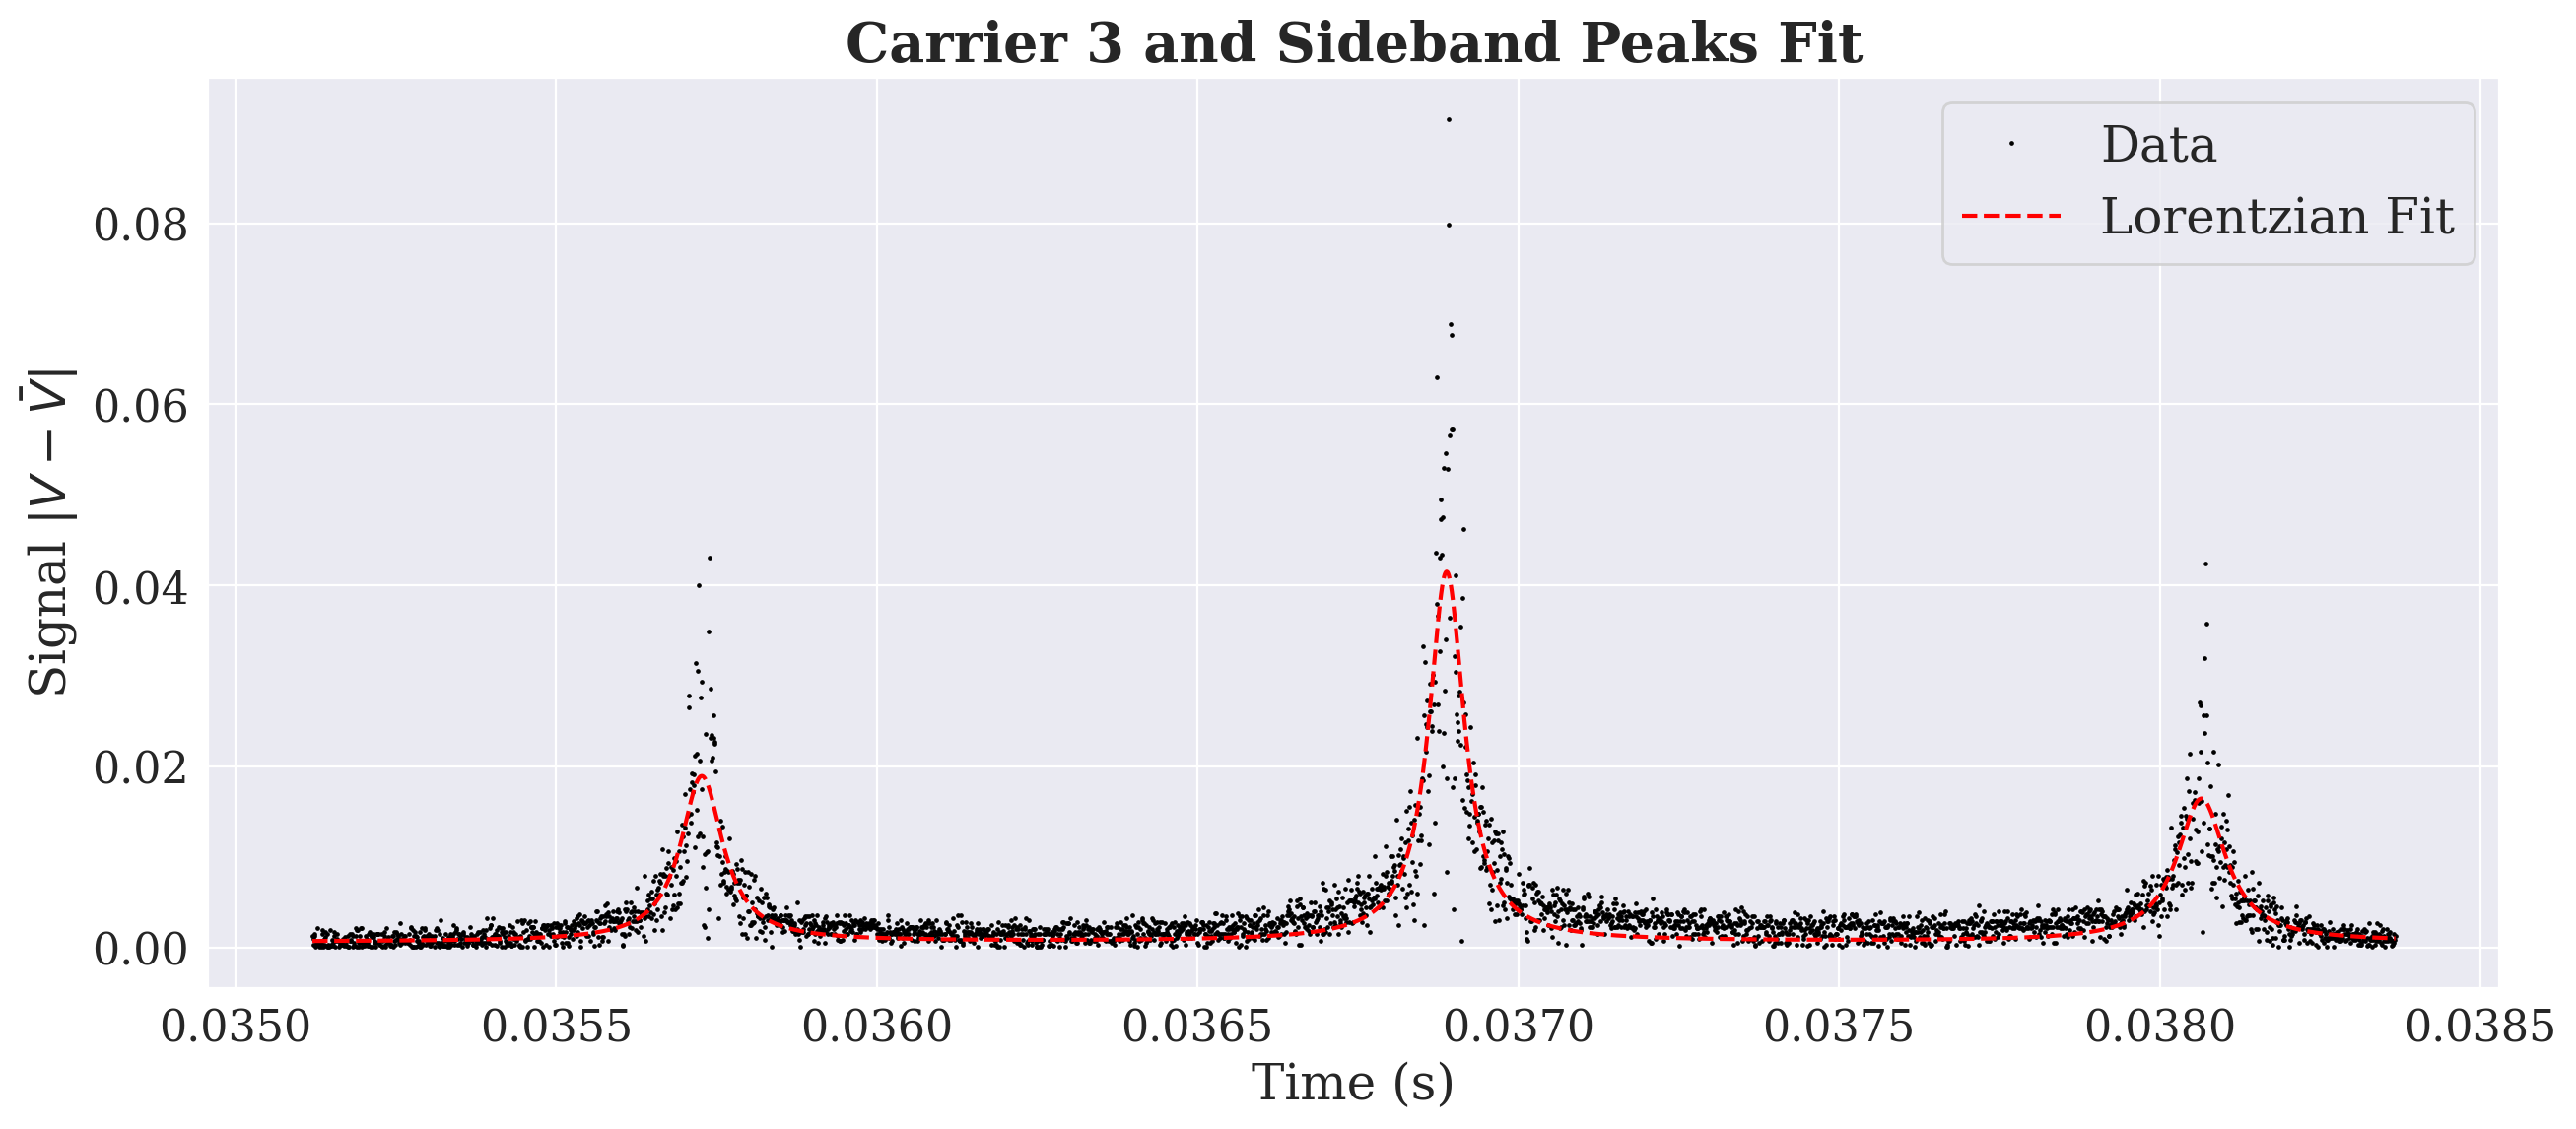

In [53]:
plt.figure(figsize=(15, 6), dpi=200)
plt.plot(time[102500:106000], abs_fast_signal[102500:106000], "ko", ms=0.7, label="Data" )
plt.plot(time[102500:106000], lor_fit[102500:106000], "r--", label="Lorentzian Fit")
plt.xlabel("Time (s)")
plt.xlabel("Time (s)")
plt.ylabel(r"Signal $| V - \bar{V} |$")
plt.title("Carrier 3 and Sideband Peaks Fit")
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [54]:
params = unp.uarray(popt_9lor, perr_9lor)

print("Lorentzian Fit Parameters: \n")
for i in range(9):
    start_idx = i * 4
    print(f"\t-------------Peak {i+1}-------------")
    print(f"\tAmplitude: {params[start_idx]}")
    print(f"\tCenter: {params[start_idx + 1]}")
    print(f"\tWidth: {params[start_idx + 2]}")
    print(f"\tHeight: {params[start_idx + 3]}\n")

Lorentzian Fit Parameters: 

	-------------Peak 1-------------
	Amplitude: 0.01837+/-0.00018
	Center: -0.0400488+/-0.0000004
	Width: (3.72+/-0.05)e-05
	Height: (0.7+/-1.3)e+02

	-------------Peak 2-------------
	Amplitude: 0.04218+/-0.00017
	Center: -0.03879123+/-0.00000016
	Width: (3.846+/-0.027)e-05
	Height: -0.11+/-0.14

	-------------Peak 3-------------
	Amplitude: 0.02557+/-0.00020
	Center: -0.03735363+/-0.00000022
	Width: (2.838+/-0.035)e-05
	Height: 0.6+/-1.4

	-------------Peak 4-------------
	Amplitude: 0.02119+/-0.00019
	Center: -0.00119338+/-0.00000029
	Width: (3.18+/-0.05)e-05
	Height: (-0.0+/-3.2)e+08

	-------------Peak 5-------------
	Amplitude: 0.03907+/-0.00017
	Center: (2.890+/-0.017)e-05
	Width: (3.891+/-0.026)e-05
	Height: (0.0+/-1.5)e+08

	-------------Peak 6-------------
	Amplitude: 0.02380+/-0.00021
	Center: 0.00127250+/-0.00000023
	Width: (2.63+/-0.04)e-05
	Height: (0.0+/-1.8)e+08

	-------------Peak 7-------------
	Amplitude: 0.01829+/-0.00017
	Center: 0.035727


Regression Parameters:

	Slope: (7.51+/-0.82)e+09
	Intercept: (4.02+/-0)e+09
	R-squared: 9.88e-01
	Standard Error: 8.24e+08
	Chi-square: 5.95


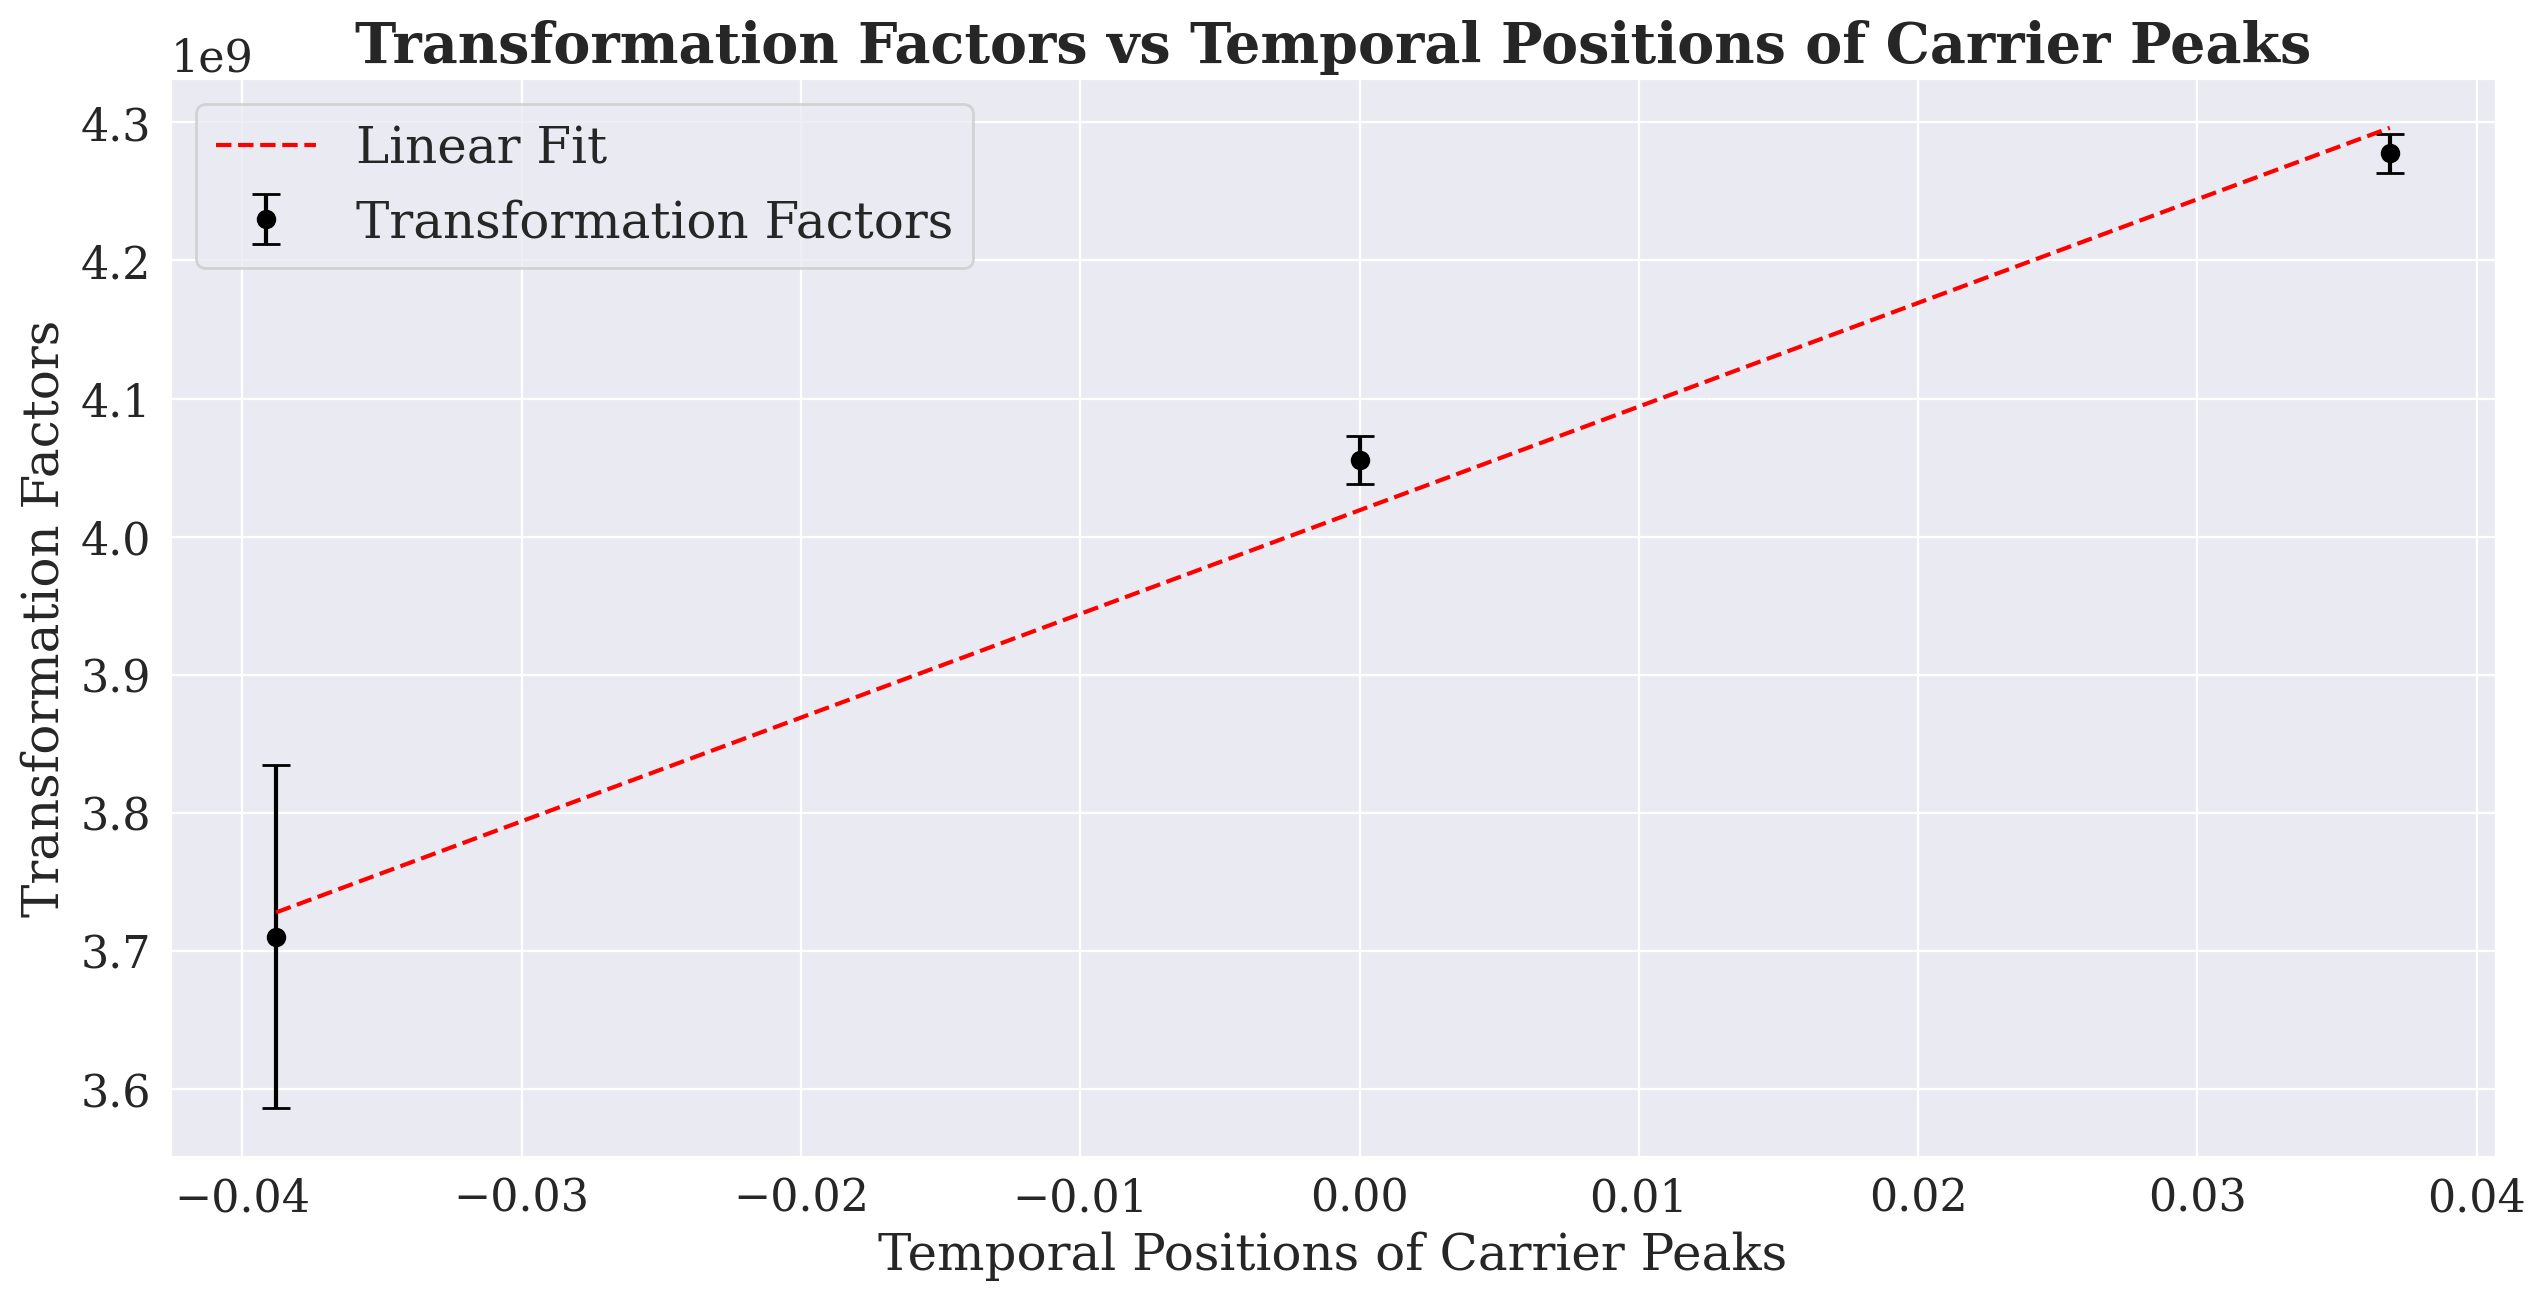

In [65]:
# Sample data (temporal positions of carrier peaks and modulation frequency)
carrier_peak_times = np.array([pars_2[1], pars_5[1], pars_8[1]]) # Temporal positions of carrier peaks in seconds
modulation_frequency = 10e6  # Modulation frequency in Hz

# Function to compute temporal distances between carrier peak and sideband peaks
def compute_temporal_distances(carrier_peak_times, sideband_peak_times):
    return np.abs(sideband_peak_times - carrier_peak_times[:, np.newaxis])

# Sample data (temporal positions of sideband peaks for each carrier peak)
sideband_peak_times = np.array([[pars_1[1], pars_3[1]], 
                                [pars_4[1], pars_6[1]], 
                                [pars_7[1], pars_9[1]]]) 

# Compute temporal distances
temporal_distances = compute_temporal_distances(carrier_peak_times, sideband_peak_times)

# Compute the variance (or standard deviation) of temporal distances for each sideband peak
variances = np.var(temporal_distances, axis=1)

# Compute variance-weighted mean temporal distances for each carrier peak
weights = 1 / variances
weights = weights[:, np.newaxis]  # Reshape weights for broadcasting
weighted_mean_temporal_distances = np.sum(weights * temporal_distances, axis=1) / np.sum(weights, axis=1)

# Compute transformation factors and their errors
transformation_factors = modulation_frequency / weighted_mean_temporal_distances
transformation_factors_errors = modulation_frequency * np.sqrt(variances) / (weighted_mean_temporal_distances ** 2)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(carrier_peak_times, transformation_factors)

# Generate points for the fitted line
fit_line = slope * carrier_peak_times + intercept

# Calculate residuals
residuals = transformation_factors - fit_line

# Compute chi-square
chi_square = np.sum((residuals / transformation_factors_errors) ** 2)

# Store slope and intercept as uncertainties
params_t_factors = unp.uarray([slope, intercept], [std_err, 0])

# Print regression parameters
print("\nRegression Parameters:\n")
print(f"\tSlope: {params_t_factors[0]:.2e}")
print(f"\tIntercept: {params_t_factors[1]:.2e}")
print(f"\tR-squared: {r_value ** 2:.2e}")
print(f"\tStandard Error: {std_err:.2e}")
print(f"\tChi-square: {chi_square:.2f}")

# Plot transformation factors against carrier peak positions with error bars and the fitted line
plt.errorbar(carrier_peak_times, transformation_factors, yerr=transformation_factors_errors, fmt='ko', label='Transformation Factors', capsize=5)
plt.plot(carrier_peak_times, fit_line, 'r--', label='Linear Fit')
plt.xlabel('Temporal Positions of Carrier Peaks')
plt.ylabel('Transformation Factors')
plt.title('Transformation Factors vs Temporal Positions of Carrier Peaks')
plt.legend(loc='best')
plt.grid(True)
plt.show()

The Transformation Formula:
$$
    \Delta \nu (t_1, t_2) = a \cdot (t_2^2 - t_1^2) + \cdot (t_2 - t_1)
$$

In [83]:
# Data (temporal positions of carrier peaks and modulation frequency)
modulation_frequency = 10e6  # Modulation frequency in Hz

# Function to compute variance-weighted mean of the free spectral range
def calculate_weighted_mean_fsr(carrier_peak_times, m, c):
    t1 = carrier_peak_times[:-1]  # First peak time
    t2 = carrier_peak_times[1:]   # Second peak time
    delta_t = t2 - t1             # Time difference between consecutive peaks
    delta_nu = m * (t2**2 - t1**2) + c * (delta_t)  # Frequency difference using the transformation formula
    weights = 1 / np.var(delta_nu)  # Variance-weighted

    # Compute variance-weighted mean
    weighted_mean = np.sum(weights * delta_nu) / np.sum(weights)
    return weighted_mean

# Given parameters
m_linear = slope
c_linear = intercept

# Calculate the variance-weighted mean of the free spectral range
weighted_mean_fsr = calculate_weighted_mean_fsr(carrier_peak_times, m_linear, c_linear)
print(f"\tVariance-weighted mean of the free spectral range: {weighted_mean_fsr:.2e} Hz")

	Variance-weighted mean of the free spectral range: 3.03e+08 Hz


### Error Signal Slope

#### Fast Loop

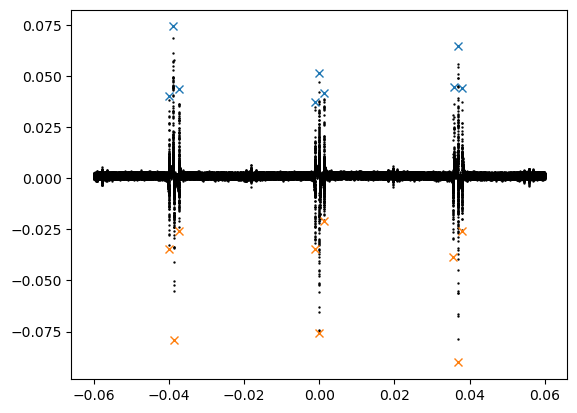

In [12]:
peaks, heights = find_peaks(fast_signal, height=0.02, distance=1000)

# Find valleys by finding peaks on the negative signal
valleys, valley_heights = find_peaks(-fast_signal, height=0.02, distance=1000)
plt.plot(time, fast_signal, 'ko', markersize=0.7)
plt.plot(time[peaks], fast_signal[peaks], "x")
plt.plot(time[valleys], fast_signal[valleys], "x")

Slope: (-3.01+/-0.72)e+03
Intercept: (-1.17+/-0)e+02
R-squared: 4.19e-01
Standard Error: 7.24e+02


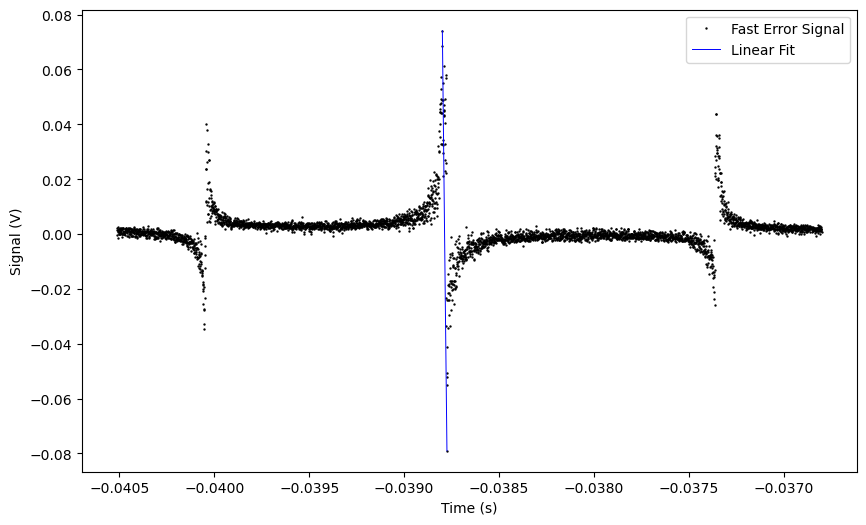

In [13]:
plt.figure(figsize=(10, 6))

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(time[22846:22872], fast_signal[22846:22872])

# Store slope and intercept as uncertainties
params_err_slope_fast = unp.uarray([slope, intercept], [std_err, 0])

print(f"Slope: {params_err_slope_fast[0]:.2e}")
print(f"Intercept: {params_err_slope_fast[1]:.2e}")
print(f"R-squared: {r_value ** 2:.2e}")
print(f"Standard Error: {std_err:.2e}")

# Define the max and min points
max_point = (peaks[1], heights["peak_heights"][1])
min_point = (valleys[1], -valley_heights["peak_heights"][1])

# Plot the error signal
plt.plot(time[21000:25000], fast_signal[21000:25000], 'ko', ms=0.7, label='Fast Error Signal')

# Plot a line from max point to min point
plt.plot([time[max_point[0]], time[min_point[0]]], [max_point[1], min_point[1]], 'b-', lw=0.7, label='Linear Fit')

# Add labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Signal (V)')
plt.legend()
plt.show()

#### Slow Loop

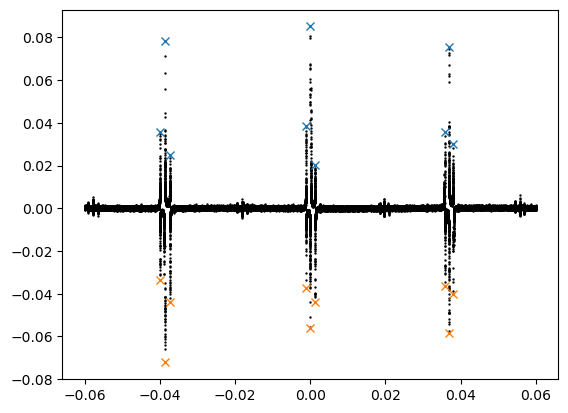

In [14]:
# Find peaks in the slow signal
peaks, heights = find_peaks(slow_signal, height=0.02, distance=1000)

# Find valleys by finding peaks on the negative signal
valleys, valley_heights = find_peaks(-slow_signal, height=0.02, distance=1000)
plt.plot(time, slow_signal, 'ko', markersize=0.7)
plt.plot(time[peaks], slow_signal[peaks], "x")
plt.plot(time[valleys], slow_signal[valleys], "x")

Slope: (2.76+/-0.60)e+03
Intercept: (1.07+/-0)e+02
R-squared: 4.67e-01
Standard Error: 6.02e+02


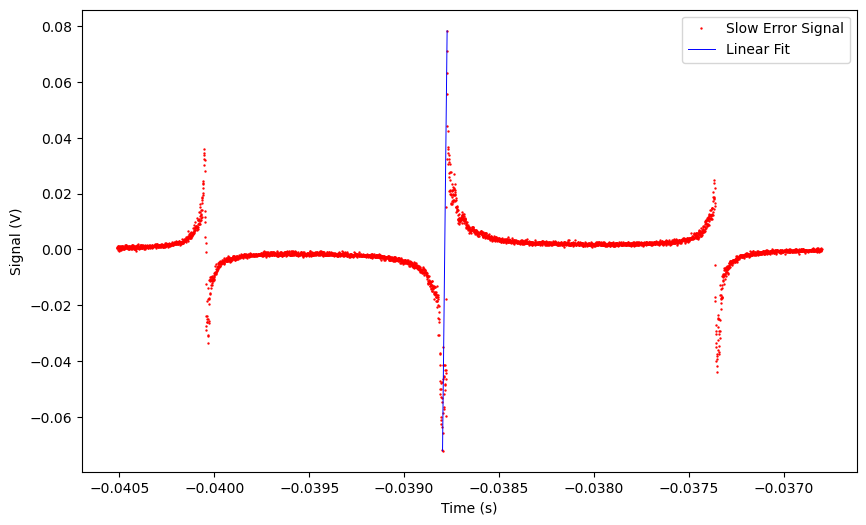

In [15]:
plt.figure(figsize=(10, 6))

# # Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(time[22846:22872], slow_signal[22846:22872])

# Store slope and intercept as uncertainties
params_err_slope_slow = unp.uarray([slope, intercept], [std_err, 0])

print(f"Slope: {params_err_slope_slow[0]:.2e}")
print(f"Intercept: {params_err_slope_slow[1]:.2e}")
print(f"R-squared: {r_value ** 2:.2e}")
print(f"Standard Error: {std_err:.2e}")

# Define the max and min points
max_point = (peaks[1], heights["peak_heights"][1])
min_point = (valleys[1], -valley_heights["peak_heights"][1])

# Plot the error signal
plt.plot(time[21000:25000], slow_signal[21000:25000], 'ro', ms=0.7, label='Slow Error Signal')

# Plot a line from max point to min point
plt.plot([time[max_point[0]], time[min_point[0]]], [max_point[1], min_point[1]], 'b-', lw=0.7, label='Linear Fit')

# Add labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Signal (V)')
plt.legend()
plt.show()

### Measure the cavity finesse via the cavity ring-down technique

$$
U(t) = U_0 \cdot \exp{\left(-\frac{t - t_0}{\tau}\right)} + U_{off}
$$

In [16]:
data1_ringdown = scipy.io.loadmat("Ringdown/20231031-0001/20231031-0001_01.mat")
x = np.concatenate(np.linspace(data1_ringdown["Tstart"], data1_ringdown["Tinterval"]*data1_ringdown["RequestedLength"] 
                               + data1_ringdown["Tstart"], 100000))
y = data1_ringdown["A"]

t0 = (-2.465+/-0.004) us
u0 = 132.364+/-0.047 mV
tau = (1.625+/-0.006) us
u_off = 29.441+/-0.033 mV


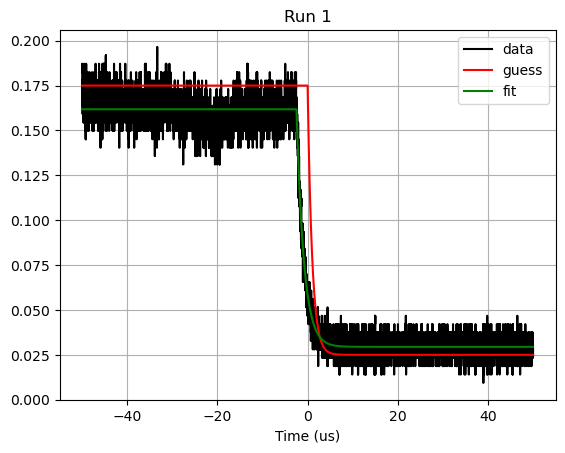

In [17]:
def fit_ringdown(t, t0, u0, tau, u_off):
    return (u0 + u_off) * (t<t0) + (u0 * np.exp(-(t-t0)/tau) + u_off) * (t>=t0)

pguess = [0, 0.15, 1e-6, 0.025] # initial guess = [t0, u0, tau, u_off]

popt, pcov = curve_fit(fit_ringdown, x[:,0], y[:,0], pguess)

y_guess = fit_ringdown(x, *pguess)
y_opt = fit_ringdown(x, *popt)

# Extract standard deviations
std_devs = np.sqrt(np.diag(pcov))

# Create uarray with parameter values and uncertainties
params = unp.uarray(popt, std_devs)

# Assign to individual parameters
t0, u0, tau, u_off = params

print(f"t0 = ({t0/1e-6:.3f}) us")
print(f"u0 = {u0/1e-3:.3f} mV")
print(f"tau = ({tau/1e-6:.3f}) us")
print(f"u_off = {u_off/1e-3:.3f} mV")

#plt.figure(dpi=300)
plt.plot(x / 1e-6, y, "k", label="data")
plt.plot(x / 1e-6, y_guess, "r-", label="guess")
plt.plot(x / 1e-6, y_opt, "g-", label="fit")
plt.legend(loc="best")
plt.title("Run 1")
plt.grid()
plt.xlabel("Time (us)")
plt.show()

In [18]:
data2_ringdown = scipy.io.loadmat("Ringdown/20231031-0001/20231031-0001_03.mat")
x = np.concatenate(np.linspace(data2_ringdown["Tstart"], data2_ringdown["Tinterval"]*data2_ringdown["RequestedLength"] 
                               + data2_ringdown["Tstart"], 100000))
y = data2_ringdown["A"]

t0 = (-2.253+/-0.004) us
u0 = 135.057+/-0.047 mV
tau = (1.644+/-0.006) us
u_off = 29.420+/-0.033 mV


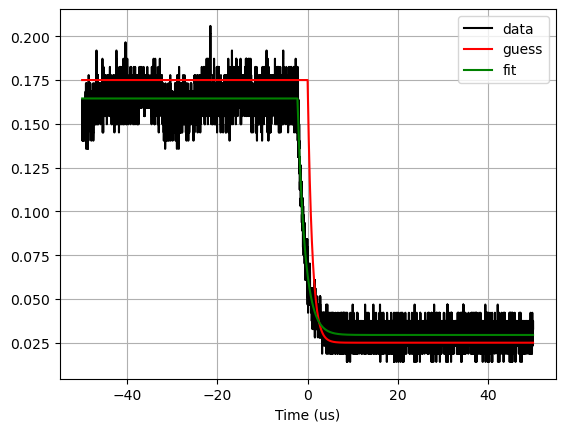

In [19]:
pguess = [0, 0.15, 1e-6, 0.025]

popt, pcov = curve_fit(fit_ringdown, x[:,0], y[:,0], pguess)

y_guess = fit_ringdown(x, *pguess)
y_opt = fit_ringdown(x, *popt)

t0, u0, tau, u_off = unp.uarray(popt, np.sqrt(np.diag(pcov)))

print(f"t0 = ({t0/1e-6:.3f}) us")
print(f"u0 = {u0/1e-3:.3f} mV")
print(f"tau = ({tau/1e-6:.3f}) us")
print(f"u_off = {u_off/1e-3:.3f} mV")

#plt.figure(dpi=300)
plt.plot(x / 1e-6, y, "k", label="data")
plt.plot(x / 1e-6, y_guess, "r-", label="guess")
plt.plot(x / 1e-6, y_opt, "g-", label="fit")
plt.legend()
plt.grid()
plt.xlabel("Time (us)")
plt.show()

In [20]:
# Perimeter:
P = ufloat(99.0e-2, 0.5e-2)

# Roundtrip time:
τ_r = P / c

# Reflectivity measure:
R = unp.sqrt(unp.exp(- P / (c * tau)))

# Mirror reflectivity: R = sqrt(R_1 * R_2 * R_3 * R_4)
R_i = unp.sqrt(R)

# Finesse:
F = np.pi * unp.sqrt(R) / (1 - R)

print("Finesse:")
print(f"\t P = {P / 1e-3:.2f} mm")
print(f"\t τ_r = {τ_r / 1e-9:.2f} ns")
print(f"\t R = {R:.5f}")
print(f"\t R_i = {R_i:.5f} = 1 - ({(1 - R_i) / 1e-6:.0f}) ppm")
print(f"\t F = {F:.0f}")

Finesse:
	 P = 990.00+/-5.00 mm
	 τ_r = 3.30+/-0.02 ns
	 R = 0.99900+/-0.00001
	 R_i = 0.99950+/-0.00000 = 1 - (502+/-3) ppm
	 F = 3128+/-20


---
## (Task B): Measurement of the scale factor
---

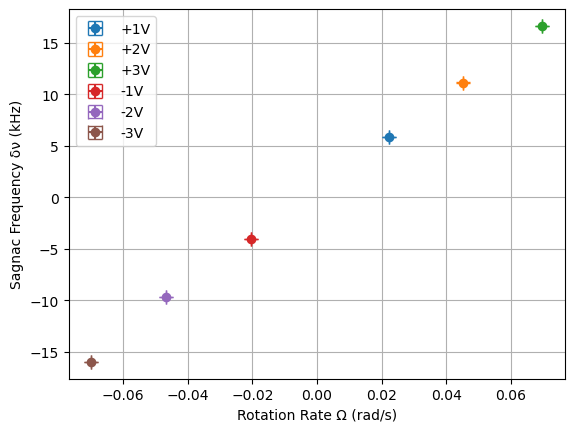

In [29]:
# Function to load data and compute mean and standard deviation
def get_mean_std(files, negate=False):
    rotation_rates = []
    sagnac_freqs = []
    
    for file in files:
        data = scipy.io.loadmat(file)
        rotation_rate = data["freq_C_"]
        sagnac_freq = data["freq_B_"]
        if negate:
            rotation_rate = -rotation_rate
            sagnac_freq = -sagnac_freq
        rotation_rates.append(rotation_rate)
        sagnac_freqs.append(sagnac_freq)
    
    rotation_rates = np.array(rotation_rates).flatten()
    sagnac_freqs = np.array(sagnac_freqs).flatten()
    rotation_rates = rotation_rates[~np.isnan(rotation_rates)]
    sagnac_freqs = sagnac_freqs[~np.isnan(sagnac_freqs)]
    
    return np.mean(rotation_rates)*4*(2*pi/(10000)), np.std(rotation_rates)*4*(2*pi/(10000))/(np.sqrt(len(rotation_rates))), np.mean(sagnac_freqs), np.std(sagnac_freqs)/(np.sqrt(len(sagnac_freqs)))

# File paths for the measurements
plus_1V_files = [
    "Allan Deviation/plus1V_30s/plus1V_30s_1.mat",
    "Allan Deviation/plus1V_30s/plus1V_30s_2.mat",
    "Allan Deviation/plus1V_30s/plus1V_30s_3.mat",
    "Allan Deviation/plus1V_30s/plus1V_30s_4.mat",
    "Allan Deviation/plus1V_30s/plus1V_30s_5.mat",
    ]

plus_2V_files = [
    "Scale Factor/plus2V/plus2V_1.mat",
    "Scale Factor/plus2V/plus2V_2.mat"
    ]

plus_3V_files = [
    "Scale Factor/plus3V/plus3V_1.mat",
    "Scale Factor/plus3V/plus3V_2.mat"
    ]

minus_1V_files = [
    "Allan Deviation/minus1V_30s/minus1V_30s_2.mat",
    "Allan Deviation/minus1V_30s/minus1V_30s_3.mat",
    "Allan Deviation/minus1V_30s/minus1V_30s_4.mat",
    "Allan Deviation/minus1V_30s/minus1V_30s_5.mat",
    "Allan Deviation/minus1V_30s/minus1V_30s_6.mat",
    "Allan Deviation/minus1V_30s/minus1V_30s_7.mat",
    "Allan Deviation/minus1V_30s/minus1V_30s_8.mat"
    ]

minus_2V_files = [
    "Scale Factor/minus2V/minus2V_1.mat",
    "Scale Factor/minus2V/minus2V_2.mat",
    "Scale Factor/minus2V/minus2V_3.mat",
    ]

minus_3V_files = [
    "Scale Factor/minus3V/minus3V_1.mat",
    "Scale Factor/minus3V/minus3V_2.mat",
    ]

# Calculate means and standard deviations
mean_rot_plus_1V, std_rot_plus_1V, mean_sag_plus_1V, std_sag_plus_1V = get_mean_std(plus_1V_files)
mean_rot_plus_2V, std_rot_plus_2V, mean_sag_plus_2V, std_sag_plus_2V = get_mean_std(plus_2V_files)
mean_rot_plus_3V, std_rot_plus_3V, mean_sag_plus_3V, std_sag_plus_3V = get_mean_std(plus_3V_files)
mean_rot_minus_1V, std_rot_minus_1V, mean_sag_minus_1V, std_sag_minus_1V = get_mean_std(minus_1V_files, negate=True)
mean_rot_minus_2V, std_rot_minus_2V, mean_sag_minus_2V, std_sag_minus_2V = get_mean_std(minus_2V_files, negate=True)
mean_rot_minus_3V, std_rot_minus_3V, mean_sag_minus_3V, std_sag_minus_3V = get_mean_std(minus_3V_files, negate=True)

# Plot the data with error bars
plt.errorbar(mean_rot_plus_1V, mean_sag_plus_1V / 1e3, xerr=std_rot_plus_1V, yerr=std_sag_plus_1V / 1e3, fmt='o', label='+1V', capsize=5)
plt.errorbar(mean_rot_plus_2V, mean_sag_plus_2V / 1e3, xerr=std_rot_plus_2V, yerr=std_sag_plus_2V / 1e3, fmt='o', label='+2V', capsize=5)
plt.errorbar(mean_rot_plus_3V, mean_sag_plus_3V / 1e3, xerr=std_rot_plus_3V, yerr=std_sag_plus_3V / 1e3, fmt='o', label='+3V', capsize=5)
plt.errorbar(mean_rot_minus_1V, mean_sag_minus_1V / 1e3, xerr=std_rot_minus_1V, yerr=std_sag_minus_1V / 1e3, fmt='o', label='-1V', capsize=5)
plt.errorbar(mean_rot_minus_2V, mean_sag_minus_2V / 1e3, xerr=std_rot_minus_2V, yerr=std_sag_minus_2V / 1e3, fmt='o', label='-2V', capsize=5)
plt.errorbar(mean_rot_minus_3V, mean_sag_minus_3V / 1e3, xerr=std_rot_minus_3V, yerr=std_sag_minus_3V / 1e3, fmt='o', label='-3V', capsize=5)

# Customize the plot
plt.xlabel("Rotation Rate Ω (rad/s)")
plt.ylabel("Sagnac Frequency δν (kHz)")
plt.legend(loc="best")
plt.grid()
plt.show()

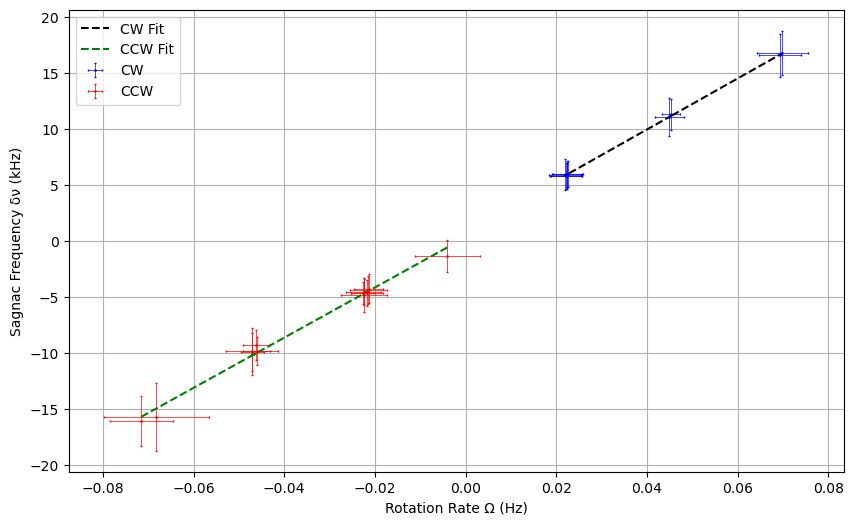

In [30]:
# Function to load data and compute mean and standard deviation
def get_mean_std(files, negate=False):
    rotation_rates = []
    sagnac_freqs = []
    
    for file in files:
        data = scipy.io.loadmat(file)
        rotation_rate = data["freq_C_"]
        sagnac_freq = data["freq_B_"]
        if negate:
            rotation_rate = -rotation_rate
            sagnac_freq = -sagnac_freq
        rotation_rates.append(rotation_rate)
        sagnac_freqs.append(sagnac_freq)
    
    rotation_rates = np.array(rotation_rates).flatten()
    sagnac_freqs = np.array(sagnac_freqs).flatten()
    rotation_rates = rotation_rates[~np.isnan(rotation_rates)]
    sagnac_freqs = sagnac_freqs[~np.isnan(sagnac_freqs)]
    
    return np.mean(rotation_rates)*4*(2*pi/(10000)), np.std(rotation_rates)*4*(2*pi/(10000)), np.mean(sagnac_freqs), np.std(sagnac_freqs)

# File paths for the measurements
positive_files = [
    ("Allan Deviation/plus1V_30s/plus1V_30s_1.mat", "+1V"),
    ("Allan Deviation/plus1V_30s/plus1V_30s_2.mat", "+1V"),
    ("Allan Deviation/plus1V_30s/plus1V_30s_3.mat", "+1V"),
    ("Allan Deviation/plus1V_30s/plus1V_30s_4.mat", "+1V"),
    ("Allan Deviation/plus1V_30s/plus1V_30s_5.mat", "+1V"),

    ("Scale Factor/plus2V/plus2V_1.mat", "+2V"),
    ("Scale Factor/plus2V/plus2V_2.mat", "+2V"),

    ("Scale Factor/plus3V/plus3V_1.mat", "+3V"),
    ("Scale Factor/plus3V/plus3V_2.mat", "+3V")
]

negative_files = [
    ("Allan Deviation/minus1V_30s/minus1V_30s_2.mat", "-1V"),
    ("Allan Deviation/minus1V_30s/minus1V_30s_3.mat", "-1V"),
    ("Allan Deviation/minus1V_30s/minus1V_30s_4.mat", "-1V"),
    ("Allan Deviation/minus1V_30s/minus1V_30s_5.mat", "-1V"),
    ("Allan Deviation/minus1V_30s/minus1V_30s_6.mat", "-1V"),
    ("Allan Deviation/minus1V_30s/minus1V_30s_7.mat", "-1V"),
    ("Allan Deviation/minus1V_30s/minus1V_30s_8.mat", "-1V"),

    ("Scale Factor/minus2V/minus2V_1.mat", "-2V"),
    ("Scale Factor/minus2V/minus2V_2.mat", "-2V"),
    ("Scale Factor/minus2V/minus2V_3.mat", "-2V"),
    ("Scale Factor/minus2V/minus2V_4.mat", "-2V"),
    
    ("Scale Factor/minus3V/minus3V_1.mat", "-3V"),
    ("Scale Factor/minus3V/minus3V_2.mat", "-3V")
]

# Lists to store the mean values for linear fit
rotation_rates_cw = []
sagnac_freqs_cw = []
rotation_rates_ccw = []
sagnac_freqs_ccw = []

# Flags to label only once
label_positive = True
label_negative = True

plt.figure(figsize=(10, 6))

# Plot positive voltages
for file, _ in positive_files:
    mean_r, std_r, mean_s, std_s = get_mean_std([file])
    rotation_rates_cw.append(mean_r)
    sagnac_freqs_cw.append(mean_s)
    if label_positive:
        plt.errorbar(mean_r, mean_s / 1e3, xerr=std_r, yerr=std_s / 1e3, fmt='o', ms=0.9, label="CW", capsize=1, elinewidth=0.5, color='blue')
        label_positive = False
    else:
        plt.errorbar(mean_r, mean_s / 1e3, xerr=std_r, yerr=std_s / 1e3, fmt='o', ms=0.9, capsize=1, elinewidth=0.5, color='blue')

# Plot negative voltages
for file, _ in negative_files:
    mean_r, std_r, mean_s, std_s = get_mean_std([file], negate=True)
    rotation_rates_ccw.append(mean_r)
    sagnac_freqs_ccw.append(mean_s)
    if label_negative:
        plt.errorbar(mean_r, mean_s / 1e3, xerr=std_r, yerr=std_s / 1e3, fmt='o', ms=0.9, label="CCW", capsize=1, elinewidth=0.5, color='red')
        label_negative = False
    else:
        plt.errorbar(mean_r, mean_s / 1e3, xerr=std_r, yerr=std_s / 1e3, fmt='o', ms=0.9, capsize=1, elinewidth=0.5, color='red')

# Linear fit for CW
coeffs_cw = np.polyfit(rotation_rates_cw, sagnac_freqs_cw, 1)
poly_cw = np.poly1d(coeffs_cw)
plt.plot(rotation_rates_cw, poly_cw(rotation_rates_cw) / 1e3, "k--", label="CW Fit")

# Linear fit for CCW
coeffs_ccw = np.polyfit(rotation_rates_ccw, sagnac_freqs_ccw, 1)
poly_ccw = np.poly1d(coeffs_ccw)
plt.plot(rotation_rates_ccw, poly_ccw(rotation_rates_ccw) / 1e3, "g--", label="CCW Fit")

# Customize the plot
plt.xlabel("Rotation Rate Ω (rad/s)")
plt.ylabel("Sagnac Frequency δν (kHz)")
plt.legend(loc="best")
plt.grid()
plt.show()

Expected Scale Factor:
$$
    K = \frac{L}{\lambda}\, \textrm{rad}^{-1} = \frac{99.0\, \textrm{cm}}{4\cdot 1064\, \textrm{nm}}\, \textrm{rad}^{-1} = 232613 \, \textrm{rad}^{-1}
$$

In [25]:
# Calculate the scale factor
P = ufloat(99.0e-2, 0.5e-2)
λ = 1064e-9

S_theo = P / (4 * λ)
print(f"\t S_theo = {S_theo / 1e3:.1f} kHz / (rad / s)")

	 S_theo = 232.6+/-1.2 kHz / (rad / s)


In [26]:
# Calculate the scale factor from the linear fit
coeffs_ccw[0], coeffs_cw[0]

(223795.66150617666, 227530.45343247874)

### Allan Deviation

In [18]:
# Define the file path template
file_path_template = "Allan Deviation/plus1V_30s/plus1V_30s_{}.mat"

# Initialize lists to hold the combined data
combined_sagnac_freq = []
combined_time = []

# Loop through each file index from 1 to 5
for i in range(1, 6):
    # Generate the file path for the current index
    file_path = file_path_template.format(i)
    
    # Load the .mat file
    data = scipy.io.loadmat(file_path)
    
    # Extract the relevant data
    Tstart = data["Tstart"][0, 0]
    Tinterval = data["Tinterval"][0, 0]
    
    # Extract and clean the Sagnac frequency data
    sagnac_freq = data["freq_B_"].flatten()
    sagnac_freq = sagnac_freq[~np.isnan(sagnac_freq)]

    # Filter the Sagnac frequency data and remove the last two points
    sagnac_freq = sagnac_freq[(sagnac_freq <= 11000)]

    # Generate the time array for the current file
    time = Tstart + Tinterval * np.arange(len(sagnac_freq))
    
    # Append the data to the combined lists
    combined_sagnac_freq.extend(sagnac_freq)
    combined_time.extend(time + (i - 1) * (time[-1] - time[0] + Tinterval))

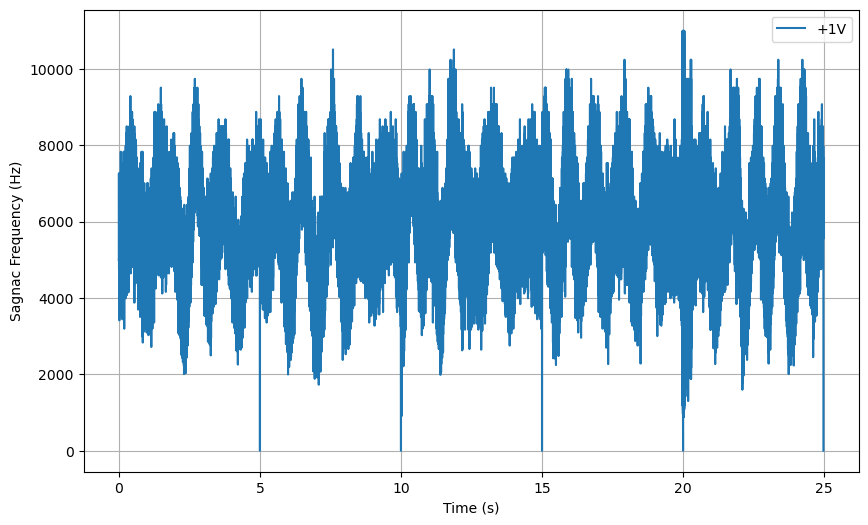

In [19]:
# Convert combined lists to numpy arrays
combined_sagnac_freq = np.array(combined_sagnac_freq)
combined_time = np.array(combined_time)

# Plot the combined data
plt.figure(figsize=(10, 6))
plt.plot(combined_time, combined_sagnac_freq, label="+1V")
plt.xlabel('Time (s)')
plt.ylabel('Sagnac Frequency (Hz)')
plt.grid(True)
plt.legend()
plt.show()

In [183]:
# From scale factor measurement:
S = ufloat(232.95, 1.00) * 1e3 # Hz / (rad / s)

# Rotation rate:
rot_rate = np.divide(combined_sagnac_freq, 232.95*1e3)

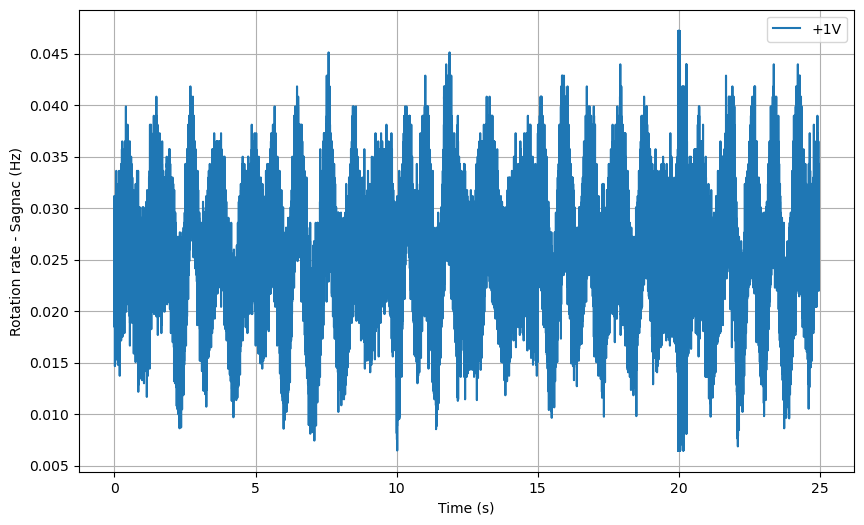

In [184]:
# Plot the combined data
plt.figure(figsize=(10, 6))
plt.plot(combined_time, rot_rate, label="+1V")
plt.xlabel('Time (s)')
plt.ylabel('Rotation rate - Sagnac (Hz)')
plt.grid(True)
plt.legend()
plt.show()

In [185]:
rate = 1/(combined_time[1] - combined_time[0])
allan = {}

taus = np.logspace(np.log10(0.1), np.log10(rot_rate.shape[0]/rate), num=100)
# taus = "octave"

# Compute the overlapping Allan deviation:
(tau, σ_ad, Δσ_ad, n_ad) = allantools.oadev(rot_rate, rate=rate, data_type="freq", taus=taus)
allan["data_oad"] = pd.DataFrame(data={"tau": tau, "σ_ad": σ_ad, "Δσ_ad": Δσ_ad, "n_ad": n_ad})

# Compute the non-overlapping Allan deviation:
(tau, σ_ad, Δσ_ad, n_ad) = allantools.adev(rot_rate, rate=rate, data_type="freq", taus=taus)
allan["data_ad"] = pd.DataFrame(data={"tau": tau, "σ_ad": σ_ad, "Δσ_ad": Δσ_ad, "n_ad": n_ad})

In [186]:
def lin_sensitivity(tau, N):
    return N / np.sqrt(tau)

tau_min = 1
tau_max = 12


for ad_type in ["oad", "ad"]:
    data = allan[f"data_{ad_type}"]
    data = data[(data["tau"] >= tau_min) &
                (data["tau"] <= tau_max)]
    
    popt, pcov = curve_fit(lin_sensitivity,
                           data["tau"], data["σ_ad"],
                           sigma=data["Δσ_ad"], p0=0.0001)
    # popt = [0.005]
    
    allan[f"fit_{ad_type}"] = {"N": ufloat(popt[0], np.sqrt(np.diag(pcov))[0]), 
                               "tau_min": tau_min,
                               "tau_max": tau_max
                               }

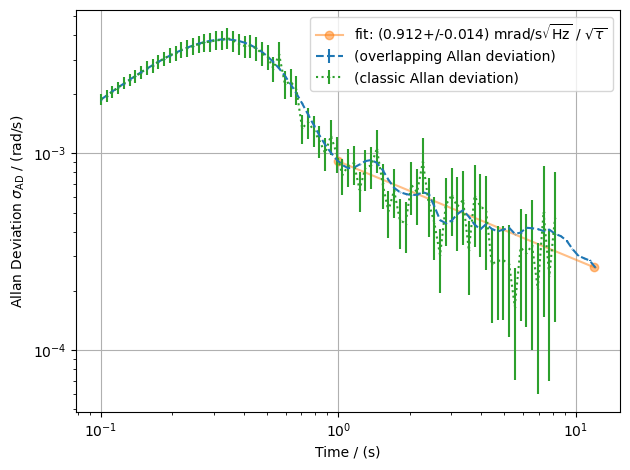

In [187]:
labels = {"oad": "overlapping Allan deviation", "ad": "classic Allan deviation"}

for ad_type, linestyle in zip(["oad", "ad"], ["--", ":"]):
    data = allan[f"data_{ad_type}"]
    fit = allan[f"fit_{ad_type}"]
    tau_fit = np.linspace(fit["tau_min"], fit["tau_max"], num=2)
    ad_fit = lin_sensitivity(tau_fit, fit["N"].nominal_value)
    plt.errorbar(data["tau"], data["σ_ad"], yerr=data["Δσ_ad"], fmt=".",
                 label=f"({labels[ad_type]})", linestyle=linestyle,
                 markersize=0.5)
    if ad_type == "oad":
        plt.plot(tau_fit, ad_fit, "o-", alpha=0.5, 
                 label=(f"fit: ({fit['N']/1e-3:.3f}) mrad/s" + 
                        r"$\sqrt{\mathrm{Hz}}$ / $\sqrt{\tau}$"))
        
plt.xscale("log")
plt.yscale("log")
#plt.ylim(1e-6, 1e-3)
plt.xlabel("Time / (s)")
plt.ylabel(r"Allan Deviation ${\sigma_\mathrm{AD}}$ / ($\mathrm{rad}/\mathrm{s}$)")
plt.grid()
plt.legend()
plt.tight_layout()